### application 데이터 세트에 다양한 feature engineering 수행. 
* application_train(test) 주요 feature값들의 분포도등의 EDA 수행. 
* application_train(test) 주요 feature 들의 추가적인 가공을 통한 feature engineering 수행. 

#### 라이브러리와 app 데이터 세트 로딩

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score,roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc,os,sys
import random

from sklearn.model_selection import KFold, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', 30)

##### 코랩 버전은 Google Drive에서 데이터 세트를 로딩

In [2]:
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#### 코랩 버전은 아래와 같이 절대 경로로 디렉토리 변경. 
default_dir = "/content/gdrive/MyDrive/Colab Notebooks/open/"
app_train = pd.read_csv(os.path.join(default_dir,'train.csv'))
app_test = pd.read_csv(os.path.join(default_dir,'test.csv'))
submission = pd.read_csv(os.path.join(default_dir,'sample_submission.csv'))

pseudo_label  = pd.read_csv(os.path.join(default_dir,'pseudo_label_2.csv'))
print(pseudo_label.columns)
print(pseudo_label.shape)

print(app_train.shape, app_test.shape)


index_0 = pseudo_label[pseudo_label['0'] > 0.5].index.tolist()
index_1 = pseudo_label[pseudo_label['1'] > 0.5].index.tolist()
index_2 = pseudo_label[pseudo_label['2'] > 0.5].index.tolist()

# index_0 = list(map(int, index_0))
# index_1 = list(map(int, index_1))
# index_2 = list(map(int, index_2))

print(index_0)
print(index_1)
print(index_2)

pseudo_df = pd.DataFrame(columns=['index', 'credit'])
for index in range(0, 10000):
    credit = 0
    # DataFrame에 특정 정보를 이용하여 data 채우기
    pseudo_df = pseudo_df.append(pd.DataFrame([[index, credit]], columns=['index', 'credit']), ignore_index=True)

pseudo_df.set_index('index', inplace=True)
print(pseudo_df.shape)



Index(['index', '0', '1', '2'], dtype='object')
(10000, 4)
(26457, 20) (10000, 19)
[6, 168, 655, 958, 1174, 1263, 1710, 1794, 2101, 2373, 2614, 2792, 2951, 3089, 3092, 3365, 3369, 3835, 3879, 4133, 4136, 4470, 4588, 5156, 5472, 6031, 6451, 6611, 6699, 7042, 7225, 7545, 7736, 7884, 8212, 8304, 8340, 8702, 9281, 9335, 9657, 9688, 9807, 9816, 9956]
[17, 31, 36, 40, 49, 50, 60, 63, 71, 92, 111, 122, 134, 140, 150, 153, 163, 184, 193, 194, 275, 284, 311, 314, 339, 343, 363, 364, 397, 447, 459, 465, 471, 474, 481, 482, 519, 585, 591, 598, 599, 635, 640, 660, 663, 664, 678, 734, 770, 783, 826, 827, 860, 870, 881, 904, 912, 913, 940, 945, 947, 962, 970, 993, 1034, 1056, 1064, 1065, 1066, 1090, 1154, 1165, 1171, 1219, 1223, 1243, 1279, 1285, 1296, 1300, 1301, 1316, 1318, 1321, 1331, 1342, 1348, 1355, 1358, 1369, 1370, 1401, 1402, 1436, 1464, 1468, 1476, 1500, 1509, 1536, 1545, 1549, 1561, 1565, 1596, 1604, 1623, 1686, 1689, 1693, 1703, 1712, 1720, 1744, 1746, 1747, 1749, 1762, 1797, 1831, 1848,

In [4]:
pseudo_df

,credit
index,
0,0
1,0
2,0
3,0
4,0
...,...
9995,0
9996,0
9997,0


In [5]:
for i in index_1:
    pseudo_df.iloc[i].replace(0,1,inplace=True)

In [6]:
for i in index_2:
    pseudo_df.iloc[i].replace(0,2,inplace=True)

In [51]:
pseudo_df.tail(10)

,credit
index,
9990,2
9991,2
9992,2
9993,2
9994,1
9995,2
9996,2
9997,2
9998,2


In [8]:
app_test['credit'] = pseudo_df['credit']

In [9]:
all_df = pd.concat([app_train, app_test])

In [10]:
all_df.isnull().sum()

index                0
gender               0
car                  0
reality              0
child_num            0
income_total         0
income_type          0
edu_type             0
family_type          0
house_type           0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
FLAG_MOBIL           0
work_phone           0
phone                0
email                0
occyp_type       11323
family_size          0
begin_month          0
credit               0
dtype: int64

In [11]:
all_df['credit'].value_counts()

2.0    25816
1.0     6939
0.0     3702
Name: credit, dtype: int64

In [12]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          36457 non-null  int64  
 1   gender         36457 non-null  object 
 2   car            36457 non-null  object 
 3   reality        36457 non-null  object 
 4   child_num      36457 non-null  int64  
 5   income_total   36457 non-null  float64
 6   income_type    36457 non-null  object 
 7   edu_type       36457 non-null  object 
 8   family_type    36457 non-null  object 
 9   house_type     36457 non-null  object 
 10  DAYS_BIRTH     36457 non-null  int64  
 11  DAYS_EMPLOYED  36457 non-null  int64  
 12  FLAG_MOBIL     36457 non-null  int64  
 13  work_phone     36457 non-null  int64  
 14  phone          36457 non-null  int64  
 15  email          36457 non-null  int64  
 16  occyp_type     25134 non-null  object 
 17  family_size    36457 non-null  float64
 18  begin_m

#### 연속형 숫자 feature들에 대해서 TARGET값이 각각 0과 1일때의 Histogram 시각화
* violinplot과 distplot으로 숫자형 feature들에 대해 TARGET값 별 분포도 비교 시각화

In [13]:
num_columns = all_df.dtypes[app_train.dtypes != 'object']
print(num_columns)

index              int64
child_num          int64
income_total     float64
DAYS_BIRTH         int64
DAYS_EMPLOYED      int64
FLAG_MOBIL         int64
work_phone         int64
phone              int64
email              int64
family_size      float64
begin_month      float64
credit            object
dtype: object


In [14]:
all_df.dtypes[all_df.dtypes != 'object'].index.tolist()

['index',
 'child_num',
 'income_total',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month']

In [15]:
def show_hist_by_target(df, columns):
    cond_2 = (df['credit'] == 2)
    cond_1 = (df['credit'] == 1)
    cond_0 = (df['credit'] == 0)
    
    for column in columns:
        fig, axs  = plt.subplots(nrows=1, ncols=1, figsize=(12, 4), squeeze=False)
        sns.distplot(df[cond_0][column], ax=axs[0][0], label='0', color='blue',rug=False, hist=False, kde=True)
        sns.distplot(df[cond_1][column], ax=axs[0][0], label='1', color='red', rug=False, hist=False, kde=True)
        sns.distplot(df[cond_2][column], ax=axs[0][0], label='2', color='green', rug=False, hist=False, kde=True)
       

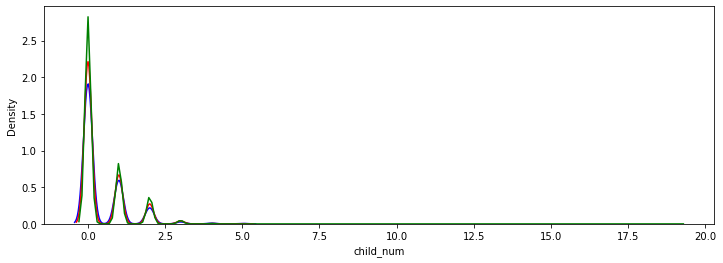

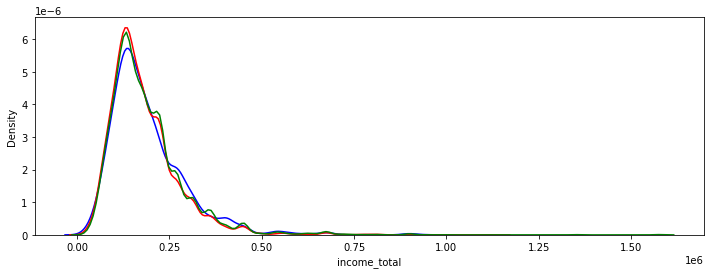

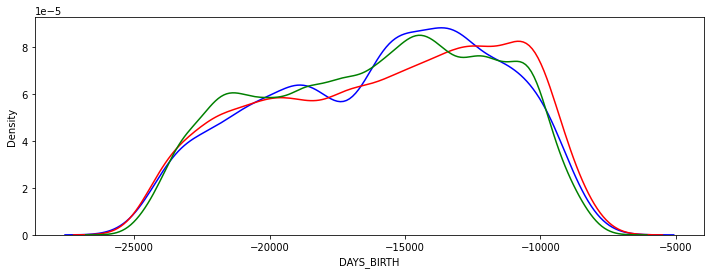

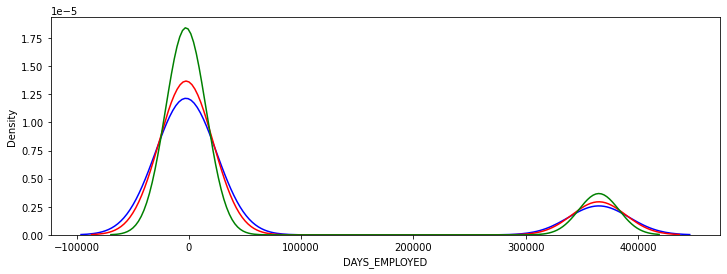

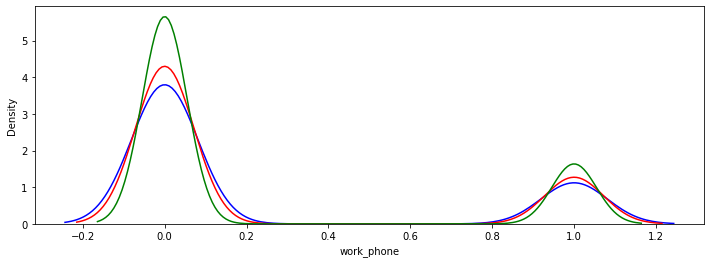

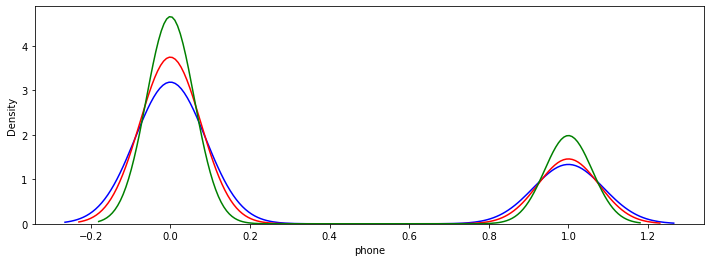

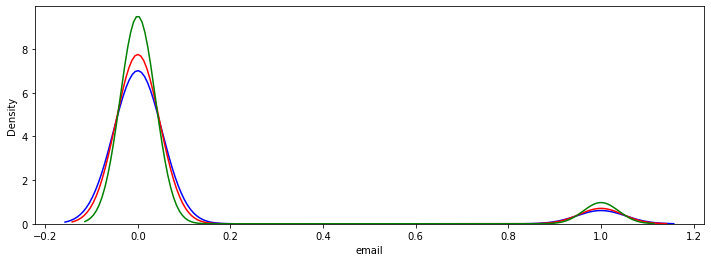

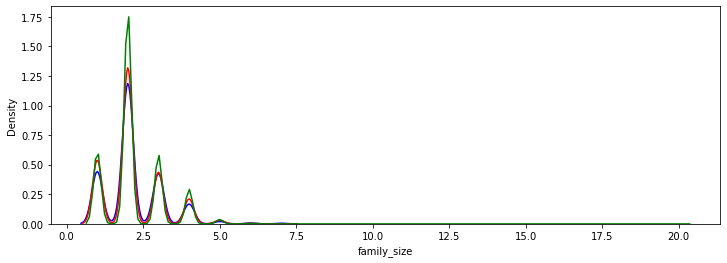

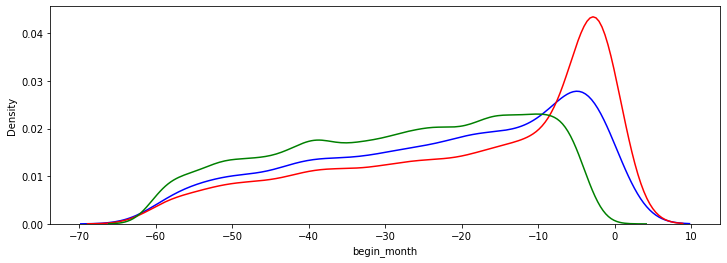

In [16]:
columns = [
 'child_num',
 'income_total',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'work_phone',
 'phone',
 'email',
 'family_size',
 'begin_month',
 ]

show_hist_by_target(all_df, columns)

* AMT_INCOME_TOTAL, AMT_CREDIT 은 크게 차이가 없음. 
* AMT_ANNUITY는 TARGET=1시 상대적으로 작은 숫자대의 값이 조금 많음. 
* AMT_GOOD_PRICE는 크게 차이가 없음. 
* DAYS_BIRTH는 TARGET=1시 적은 연령대의 숫자값이 상대적으로 많음. 
* DAYS_EMPLOYED는 TARGET=1시 작은 값들이 조금 더 많음. 
* DAYS_ID_PUBLISH, DAYS_REGISTRATION  는 TARGET=1시 최근 값들이 조금 더 많음. 
* DAYS_LAST_PHONE_CHANGE는 큰 차이 없음. 
* CNT_FAM_MEMBERS는 차이가 없음. outlier 때문에 histogram에 차이가 있어 보임. 
* REGION_RATING_CLIENT는 큰 차이 없음 
* EXT_SOURCE_1,EXT_SOURCE_2, EXT_SOURCE_3 모두 조금씩 차이가 있음.  
* 나머지 컬럼모두 큰 차이가 없음. 
* 전반적으로 연령대가 낮은(직장 경력이 적은), 소액 대출에서 상대적으로 연체 비중이 높음.  

#### seaborn의 countplot() 또는 catplot()을 이용하여 category 피처(object 컬럼)을 TARGET 유형에 따라 Count 비교

In [17]:
object_columns = all_df.dtypes[all_df.dtypes=='object'].index.tolist()
object_columns

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'credit']

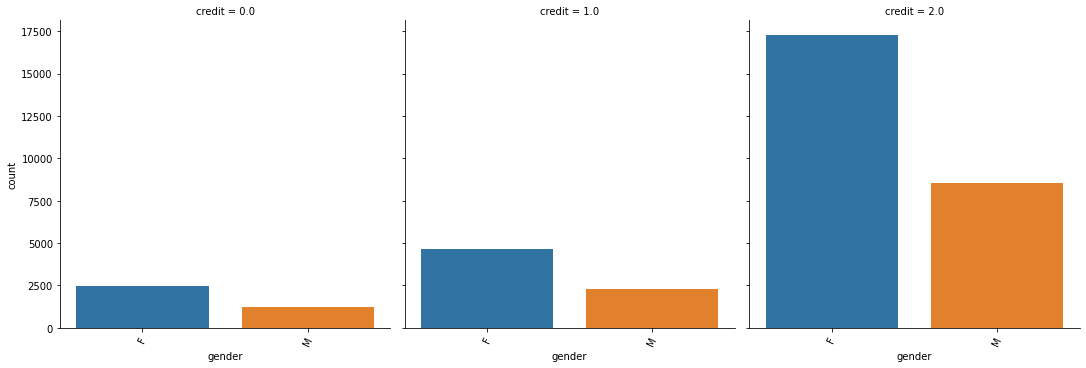

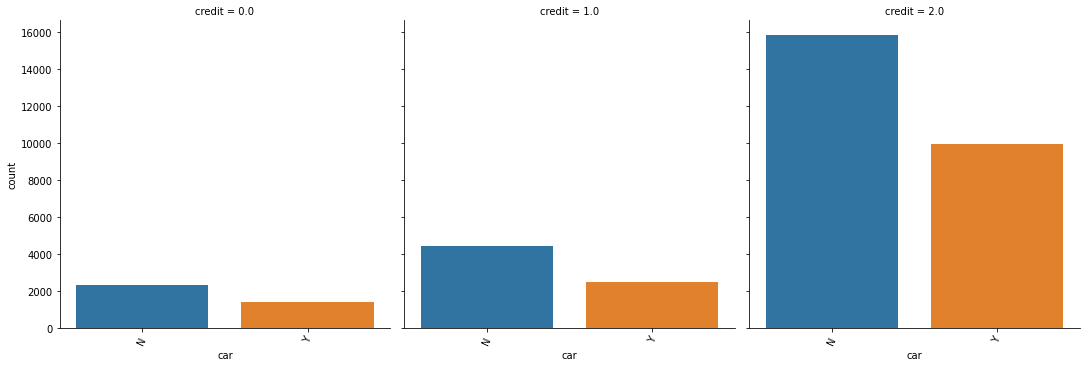

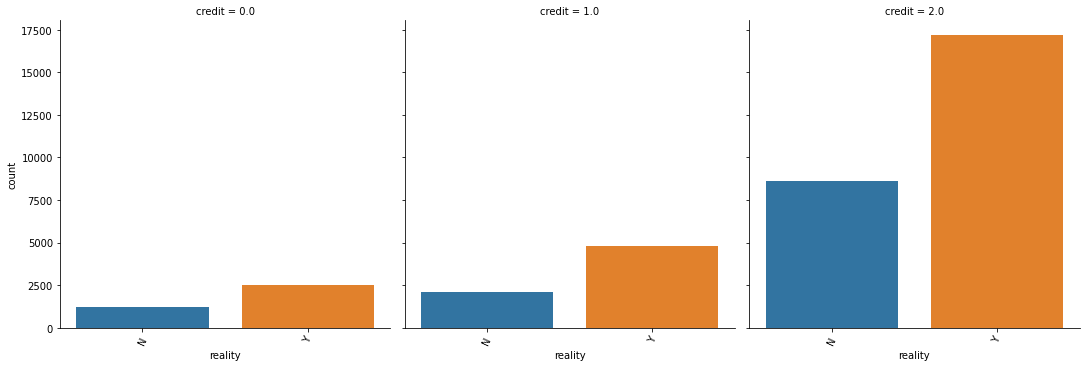

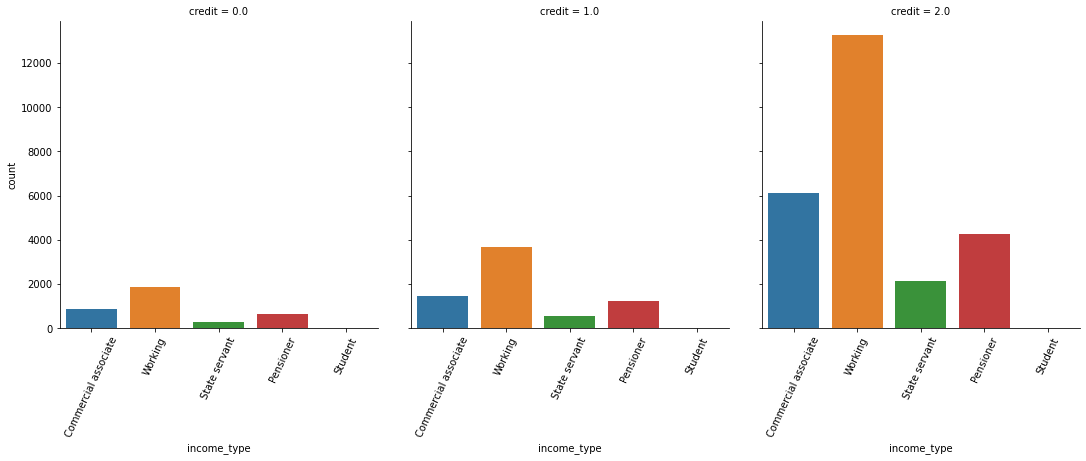

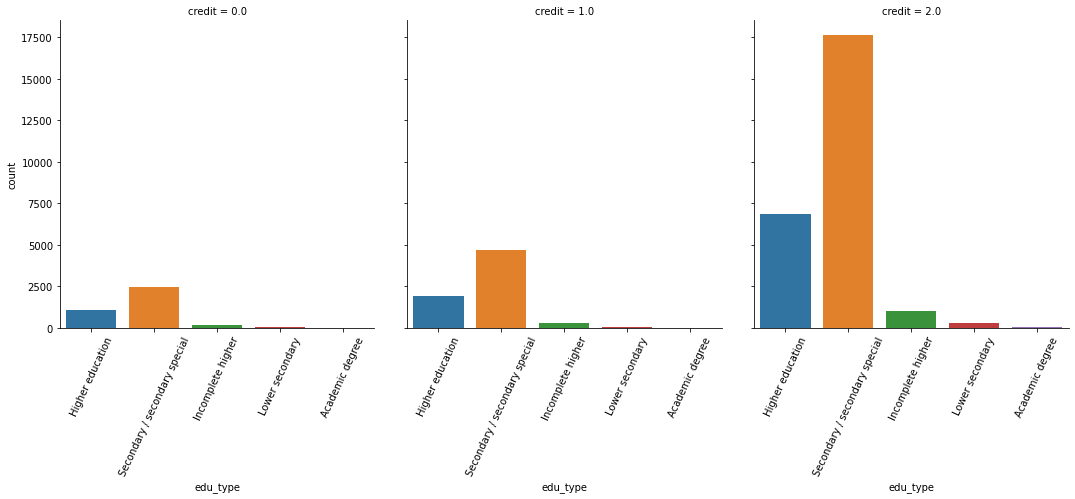

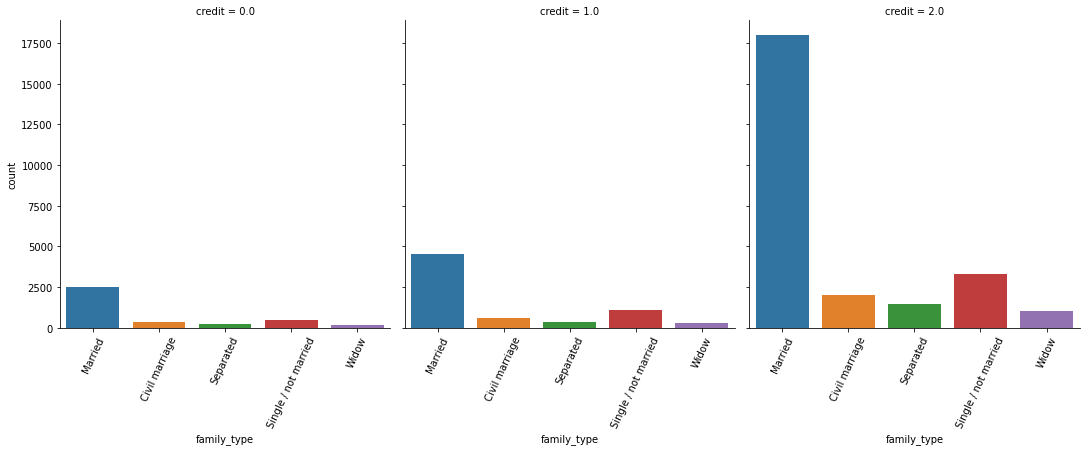

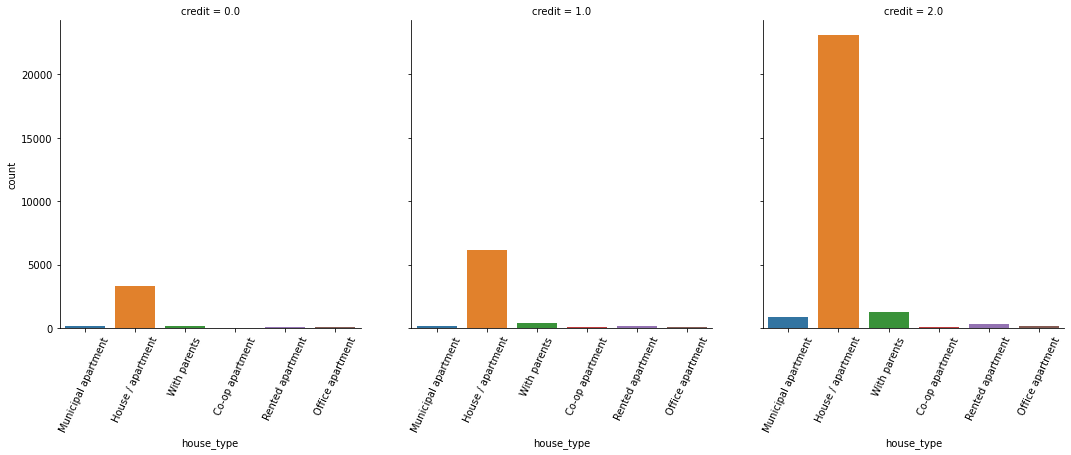

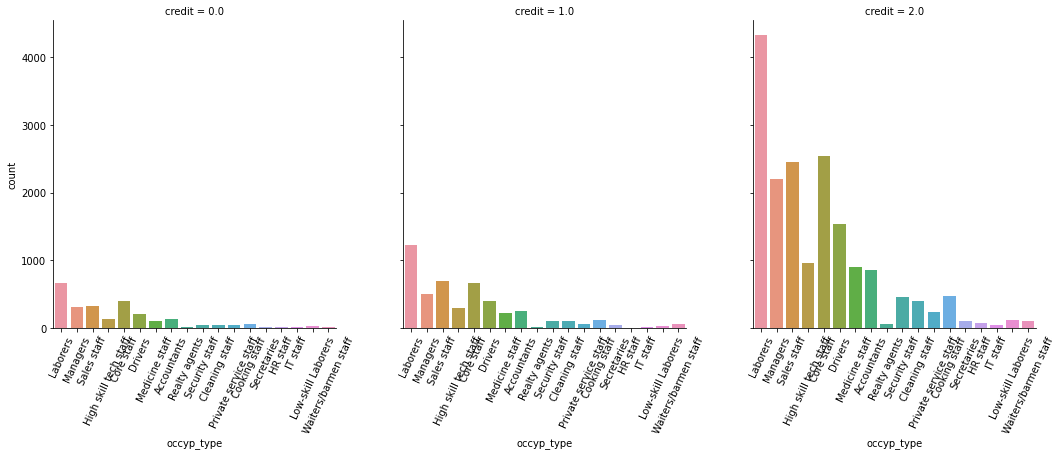

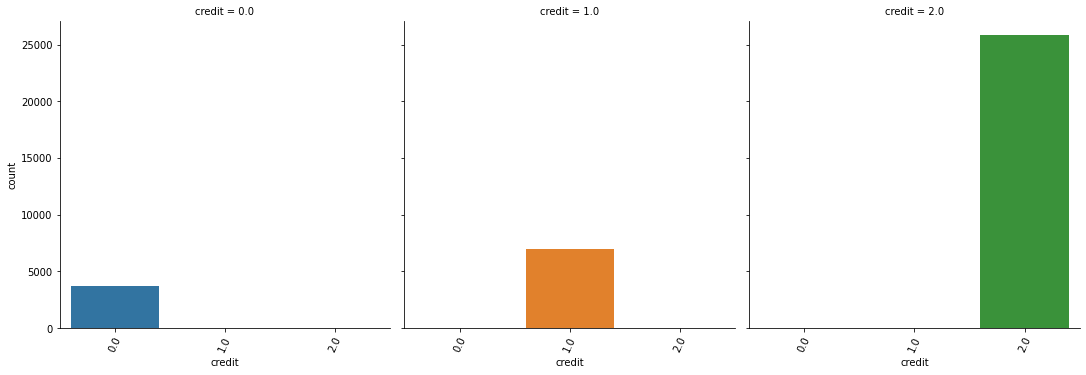

In [18]:
# catplot을 이용하여 TARGET별로 여러컬럼의 category 값 Histogram을 표현.  
def show_category_by_target(df, columns):
    for column in columns:
        chart = sns.catplot(x=column, col="credit", data=df, kind="count")
        chart.set_xticklabels(rotation=65)
        
show_category_by_target(all_df, object_columns)

#### 대출 횟수 대비 연체 비율이 남성이 여성보다 높음. 이를 value_counts()로 확인. 

In [19]:
# cond_1 = (app_train['TARGET'] == 1)
# cond_0 = (app_train['TARGET'] == 0)
# cond_f = (app_train['CODE_GENDER'] == 'F')
# cond_m = (app_train['CODE_GENDER'] == 'M')

# # 전체 건수 대비 남성과 여성의 비율 확인
# print(app_train['CODE_GENDER'].value_counts()/app_train.shape[0])
# # TARGET=1 일 경우 남성과 여성의 비율 확인
# print(app_train[cond_1]['CODE_GENDER'].value_counts()/app_train[cond_1].shape[0])
# # TARGET=0 일 경우 남성과 여성의 비율 확인
# print(app_train[cond_0]['CODE_GENDER'].value_counts()/app_train[cond_0].shape[0])

#### 주요 컬럼들의 target과의 상관도 분석

In [20]:
all_df.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [21]:
corr_columns = [ 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit']

corr = all_df[corr_columns].corr()

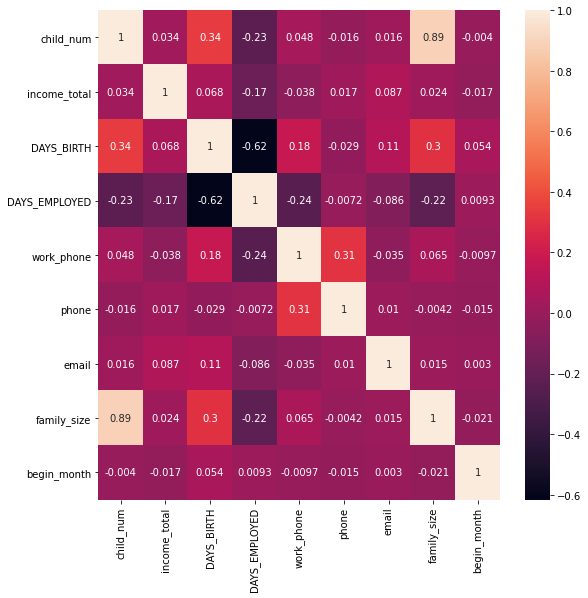

In [22]:
plt.figure(figsize=(9, 9))
sns.heatmap(corr, annot=True)

### 주요 Feature들에 대한 feature engineering 수행

#### 이상치 데이터 확인 및 DAYS_EMPLOYED 이상치 값 변경 

이상치 제거 함수

In [23]:
# def remove_outlier(train, columns):
#     df = train[columns]

#     # 1분위수
#     quan_25 = np.percentile(df.values, 25)

#     # 3분위수
#     quan_75 = np.percentile(df.values, 75)

#     iqr = quan_75 - quan_25

#     lowest = quan_25 - iqr*1.5
#     highest = quan_75 + iqr*1.5
#     outlier_index = df[(df < lowest) | (df > highest)].index
#     print('outlier의 수 : ', len(outlier_index))
#     train.drop(outlier_index, axis=0, inplace=True)

#     return train

정규화 함수

In [24]:
def normalization(train, columns):
    for column in columns:
        train[column] = (train[column] - min(train[column])) / (max(train[column]) - min(train[column]))
        return train


In [25]:
# 수치데이터 특성 확인
print(all_df.dtypes[all_df.dtypes != 'object'].index.tolist())

columns = ['child_num','income_total','DAYS_BIRTH','DAYS_EMPLOYED', 'family_size', 'begin_month']

all_df[columns].describe()

['index', 'child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'family_size', 'begin_month']


,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month
count,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.000000,36457.000000
mean,0.430315,1.866857e+05,-15975.173382,59262.935568,2.198453,-26.164193
std,0.742367,1.017892e+05,4200.549944,137651.334859,0.911686,16.501854
min,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.000000,-60.000000
25%,0.000000,1.215000e+05,-19438.000000,-3153.000000,2.000000,-39.000000
50%,0.000000,1.575000e+05,-15563.000000,-1552.000000,2.000000,-24.000000
75%,1.000000,2.250000e+05,-12462.000000,-408.000000,3.000000,-12.000000
max,19.000000,1.575000e+06,-7489.000000,365243.000000,20.000000,0.000000


In [26]:
### 365243이 매우 많음. 약 1000년치에 해당하는 날짜임.  
all_df['DAYS_EMPLOYED'].value_counts()

 365243    6135
-401         78
-1539        64
-200         63
-2087        61
           ... 
-3640         1
-5717         1
-4420         1
-2203         1
-2024         1
Name: DAYS_EMPLOYED, Length: 3640, dtype: int64

In [27]:
# LightGBM은 NULL값을 트리 모델 생성하는데 사용할 수 있으므로 일괄적으로 Null로 변환 
all_df['DAYS_EMPLOYED'] = all_df['DAYS_EMPLOYED'].replace(365243, np.nan)
all_df['DAYS_EMPLOYED'].value_counts(dropna=False)

 NaN       6135
-401.0       78
-1539.0      64
-200.0       63
-2087.0      61
           ... 
-5095.0       1
-2110.0       1
-3542.0       1
-2194.0       1
-7687.0       1
Name: DAYS_EMPLOYED, Length: 3640, dtype: int64

skew 되어있는 데이터 정규화 실행

In [28]:
skew_columns = ['income_total','DAYS_EMPLOYED','family_size']

all_df = normalization(all_df, skew_columns)

이상치 제거

In [29]:
# for column in skew_columns:
    # all_df = remove_outlier(all_df, column)

#### 상관도가 높은 변수 및 결측치가 많은 변수 제거

In [30]:
all_df = all_df.drop(['phone', 'child_num', 'occyp_type', 'FLAG_MOBIL','email'], axis=1)

In [31]:
all_df.columns

Index(['index', 'gender', 'car', 'reality', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'work_phone', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [32]:
all_df.dtypes[all_df.dtypes != 'object'].index.tolist()

['index',
 'income_total',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'work_phone',
 'family_size',
 'begin_month']

In [33]:
def label_encoder(c):
    le = LabelEncoder()
    return le.fit_transform(c.astype(str))

In [34]:
scaler = StandardScaler()

In [35]:
label_cols = ['gender','car','reality']
onehot_cols = ['income_type', 'edu_type', 'family_type', 'house_type']
numerical_cols = ['income_total','DAYS_BIRTH','DAYS_EMPLOYED','work_phone','family_size','begin_month']

In [36]:
all_df[numerical_cols] = scaler.fit_transform(all_df[numerical_cols])

In [37]:
onehot_encoded_df = pd.get_dummies(all_df[onehot_cols])
label_encoded_df = all_df[label_cols].apply(label_encoder)
numerical_df = pd.DataFrame(all_df[numerical_cols],columns=numerical_cols)
target_df = all_df['credit']

concat_df = pd.concat([numerical_df, label_encoded_df, onehot_encoded_df, target_df], axis=1)

#### 데이터 레이블 인코딩, NULL값은 LightGBM 내부에서 처리하도록 특별한 변경하지 않음. 

#### 학습 데이터와 테스트 데이터 다시 분리

In [38]:
X = concat_df.drop('credit', axis=1)
y = concat_df['credit']

test = concat_df[len(app_train):].drop(['credit'], axis=1)

X.shape, y.shape, test.shape

((36457, 30), (36457,), (10000, 30))

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y.astype(int), test_size=0.2, random_state=0)


In [40]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric= 'logloss', verbose= 100, early_stopping_rounds= 100)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 0.688641	valid_0's multi_logloss: 0.688641
[200]	valid_0's multi_logloss: 0.670788	valid_0's multi_logloss: 0.670788
[300]	valid_0's multi_logloss: 0.662789	valid_0's multi_logloss: 0.662789
[400]	valid_0's multi_logloss: 0.656599	valid_0's multi_logloss: 0.656599
[500]	valid_0's multi_logloss: 0.652502	valid_0's multi_logloss: 0.652502
[600]	valid_0's multi_logloss: 0.649273	valid_0's multi_logloss: 0.649273
[700]	valid_0's multi_logloss: 0.646722	valid_0's multi_logloss: 0.646722
[800]	valid_0's multi_logloss: 0.644589	valid_0's multi_logloss: 0.644589
[900]	valid_0's multi_logloss: 0.642957	valid_0's multi_logloss: 0.642957
[1000]	valid_0's multi_logloss: 0.641727	valid_0's multi_logloss: 0.641727
Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 0.641727	valid_0's multi_logloss: 0.641727


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.02, max_depth=12,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=32, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=-1,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0,
               verbose=-1)

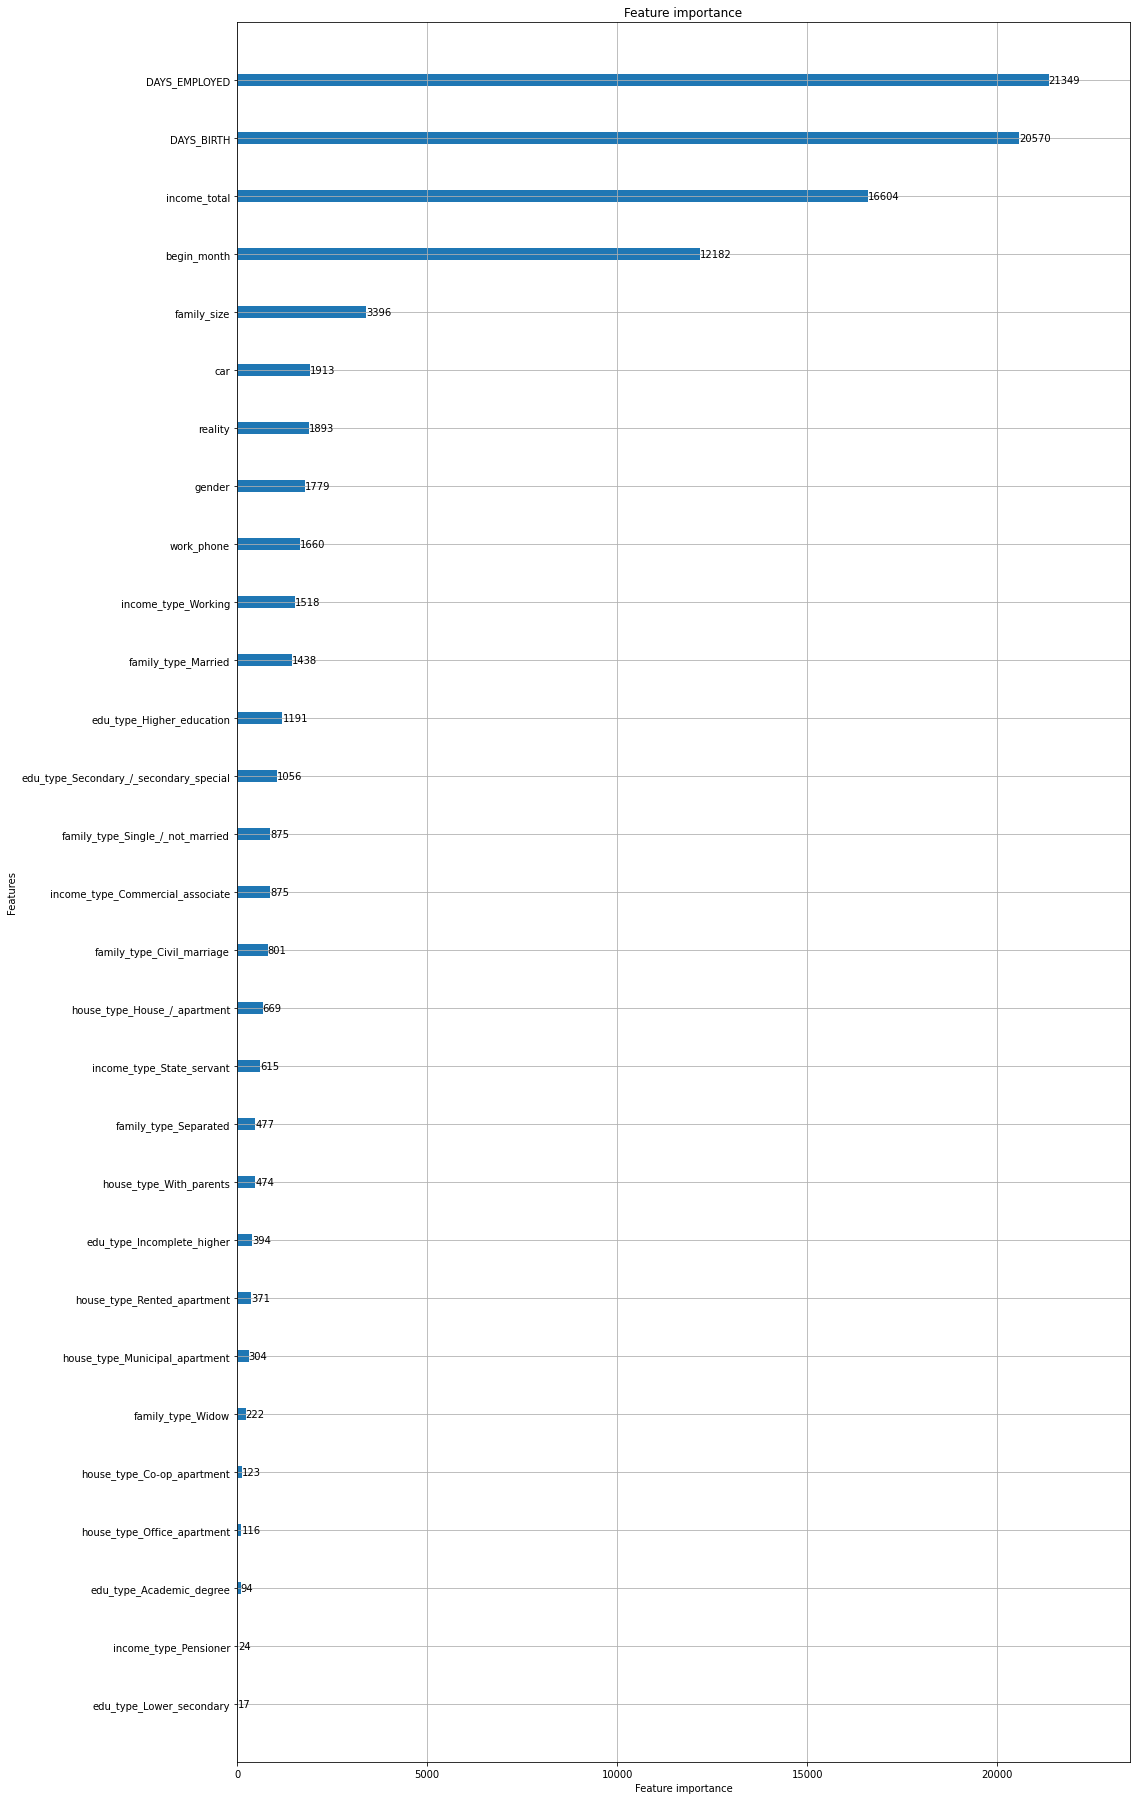

In [41]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32))

In [42]:
from sklearn.metrics import accuracy_score, log_loss
from tensorflow.keras.utils import to_categorical

y_pred = clf.predict_proba(X_test)
print(f"log_loss: {log_loss(to_categorical(y_test), y_pred)}")

log_loss: 0.6417267636357964


In [43]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test.shape[0], 3))  
    for n_fold, (train_index, val_index) in enumerate(folds.split(X, y.astype(int))):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        clf.fit(X_train, y_train.astype(int))
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test)
        
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf)

FOLD 0 : logloss:0.6430641878903435
FOLD 1 : logloss:0.6438183766249278
FOLD 2 : logloss:0.6289892950755813
FOLD 3 : logloss:0.6377537249436671
FOLD 4 : logloss:0.6409933643534514
Mean:0.6389237897775942


In [44]:
my_submission

array([[0.03975403, 0.07712186, 0.88312411],
       [0.09779906, 0.10147148, 0.80072946],
       [0.04665853, 0.0743086 , 0.87903287],
       ...,
       [0.02779728, 0.05394912, 0.9182536 ],
       [0.06069621, 0.12197962, 0.81732417],
       [0.08721445, 0.15402648, 0.75875907]])

In [45]:
submission

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0
...,...,...,...,...
9995,36452,0,0,0
9996,36453,0,0,0
9997,36454,0,0,0
9998,36455,0,0,0


In [46]:
submission.loc[:,1:]=my_submission

In [47]:
submission

,index,0,1,2
0,26457,0.039754,0.077122,0.883124
1,26458,0.097799,0.101471,0.800729
2,26459,0.046659,0.074309,0.879033
3,26460,0.108862,0.100169,0.790969
4,26461,0.077672,0.132504,0.789824
...,...,...,...,...
9995,36452,0.117027,0.152793,0.730180
9996,36453,0.077992,0.201239,0.720770
9997,36454,0.027797,0.053949,0.918254
9998,36455,0.060696,0.121980,0.817324


In [48]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/open')

In [52]:
submission.to_csv('5_6_submission.csv', index=False)